# 准备工作

## 安装MindQuantum

可以采用pip安装mindquantum与mindspore环境
```zsh
pip install mindquantum mindspore==1.8 mindvision
```

## 下载数据集

点击链接进入Kaggle准备数据集

[数据集下载链接](https://www.kaggle.com/datasets/pcbreviglieri/pneumonia-xray-images)

解压数据文件
```zsh
unzip archieve.zip
```

# Datasets

Mindspore提供了数据处理模块```mindspore.dataset```，Dataset在程序中可以为网络提供所有的样本和对应的标签，以及处理数据集的划分和迭代。

可以使用mindspore提供的ImageFolderDataset进行数据的导入。

In [1]:
# 构建数据集
import mindspore.dataset as ds
import matplotlib.pyplot as plt
import numpy as np
from mindspore.dataset import ImageFolderDataset

batch_size = 64
class_index = {'normal': 0, 'opacity': 1}
train_ds_dir = r'./archive/train'
train_ds = ImageFolderDataset(dataset_dir=train_ds_dir, \
    class_indexing=class_index, decode=True)
load_img_ops = ds.transforms.Compose([
    ds.vision.Rescale(1./255, 0),
    ds.vision.Resize((128, 128)),
    ds.vision.HWC2CHW()
])
train_ds = train_ds.map(load_img_ops, input_columns='image')
# 将Label的shape设置成[N, 1]与神经网络的输出适配
train_ds = train_ds.map([lambda x: [x], ds.transforms.TypeCast(np.float32)], input_columns='label')
train_ds = train_ds.batch(batch_size)

使用同样的方法加载验证集。

In [2]:
val_ds_dir = r'./archive/val'
val_ds = ImageFolderDataset(dataset_dir=val_ds_dir, \
    class_indexing=class_index, decode=True)
val_ds = val_ds.map(load_img_ops, input_columns='image')
val_ds = val_ds.map([lambda x: [x], ds.transforms.TypeCast(np.float32)], input_columns='label')
val_ds = val_ds.batch(batch_size)

检验dataset的数据格式

Batch Size = 64


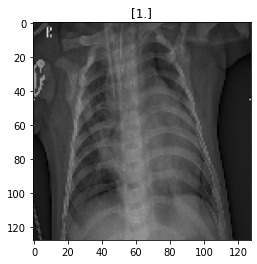

In [3]:
%matplotlib inline
imgs, labels = next(train_ds.create_tuple_iterator())
plt.imshow(imgs.asnumpy()[0].transpose(1, 2, 0))
plt.title(labels[0])
print('Batch Size =', len(imgs))

# 经典网络

首先按照论文中的结构构建经典网络
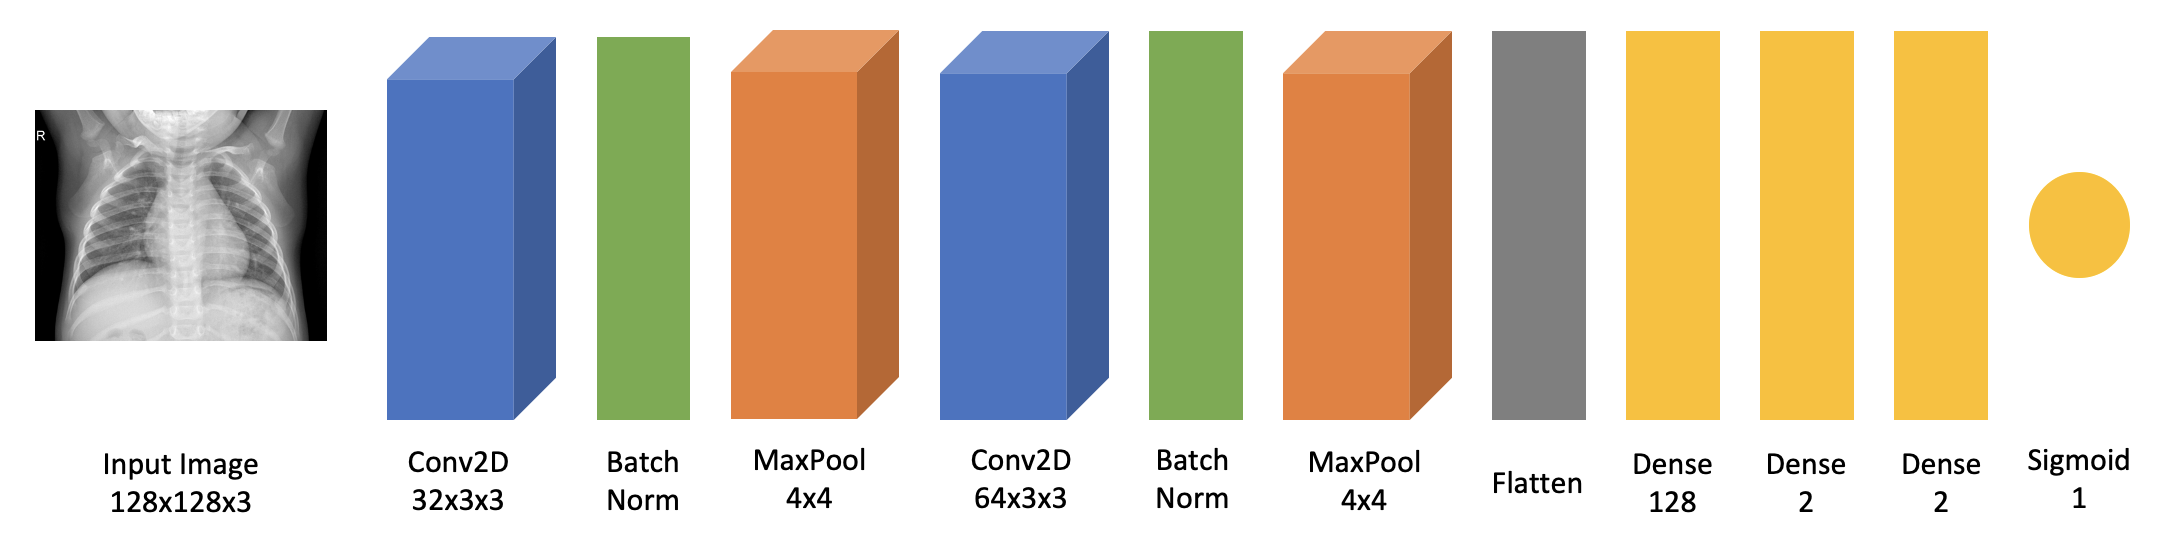

In [4]:
# 构建经典网络

from mindspore import nn
from mindspore.common.initializer import XavierUniform
class Network(nn.Cell):
    def __init__(self):
        super().__init__()
        in_channels = 3
        hidden_dim = 32
        hidden_dim_l2 = 64
        self.net_sequential = nn.SequentialCell(
            nn.Conv2d(in_channels, hidden_dim, 3, weight_init=XavierUniform()),
            nn.BatchNorm2d(hidden_dim),
            nn.MaxPool2d(4, stride=4),
            nn.Conv2d(hidden_dim, hidden_dim_l2, 3, weight_init=XavierUniform()),
            nn.BatchNorm2d(hidden_dim_l2),
            nn.MaxPool2d(4, stride=4),
            nn.Flatten(),
            nn.Dense(4096, 128, activation='relu', weight_init=XavierUniform()),
            nn.Dense(128, 2, activation='relu', weight_init=XavierUniform()),
            nn.Dense(2, 1, weight_init=XavierUniform()),
            nn.Sigmoid(),
        )

    def construct(self, x):
        logits = self.net_sequential(x)
        return logits

检验网络结构和输出

In [5]:
classical_net = Network()
from mindspore.common.initializer import Uniform
import mindspore as ms

total_params = 0
for param in classical_net.trainable_params():
    print(param.shape)
    total_params += np.prod(param.shape)
print('共有%d参数' % total_params)

img = ms.Tensor(shape=(2, 3, 128, 128), dtype=ms.float32, init=Uniform())
x = img
for cell in classical_net.net_sequential:
    x = cell(x)
    print('-'*30)
    print('网络层', cell)
    if len(cell.parameters_dict()) > 0:
        weight_param = list(cell.parameters_dict().values())[0]
        print('网络单元', weight_param.shape)
    print('输出数据尺寸', x.shape)

(32, 3, 3, 3)
(32,)
(32,)
(64, 32, 3, 3)
(64,)
(64,)
(128, 4096)
(128,)
(2, 128)
(2,)
(1, 2)
(1,)
共有544165参数
------------------------------
网络层 Conv2d<input_channels=3, output_channels=32, kernel_size=(3, 3), stride=(1, 1), pad_mode=same, padding=0, dilation=(1, 1), group=1, has_bias=False, weight_init=<mindspore.common.initializer.XavierUniform object at 0x7f7e10660810>, bias_init=zeros, format=NCHW>
网络单元 (32, 3, 3, 3)
输出数据尺寸 (2, 32, 128, 128)
------------------------------
网络层 BatchNorm2d<num_features=32, eps=1e-05, momentum=0.09999999999999998, gamma=Parameter (name=net_sequential.1.gamma, shape=(32,), dtype=Float32, requires_grad=True), beta=Parameter (name=net_sequential.1.beta, shape=(32,), dtype=Float32, requires_grad=True), moving_mean=Parameter (name=net_sequential.1.moving_mean, shape=(32,), dtype=Float32, requires_grad=False), moving_variance=Parameter (name=net_sequential.1.moving_variance, shape=(32,), dtype=Float32, requires_grad=False)>
网络单元 (32,)
输出数据尺寸 (2, 32, 128, 128

In [6]:
ms.set_context(mode=ms.GRAPH_MODE, device_target="CPU")

In [7]:
from mindvision.engine.callback import LossMonitor

learning_rate = 0.01

# 损失函数和优化器定义
crit = nn.BCELoss(reduction='mean')
opt = nn.SGD(classical_net.trainable_params(), learning_rate=learning_rate)

# 使用Model托管训练网络
classical_model = ms.Model(network=classical_net, loss_fn=crit, optimizer=opt, metrics={'Loss': nn.Loss()})

history_cb = ms.History()
classical_val_loss = []
epoch_num = 10
# 经典模型训练
for epoch in range(epoch_num):
    classical_model.train(epoch+1, train_ds, callbacks=[LossMonitor(learning_rate), history_cb], initial_epoch=epoch, dataset_sink_mode=False)
    eval_result = classical_model.eval(val_ds)      # 执行模型评估
    classical_val_loss.append(eval_result['Loss'])
    print(history_cb.epoch, history_cb.history)
    print(eval_result)
classical_train_loss = history_cb.history['net_output']

Epoch:[  0/  1], step:[    1/   66], loss:[0.435/0.435], time:6703.689 ms, lr:0.01000
Epoch:[  0/  1], step:[    2/   66], loss:[2.195/1.315], time:2996.542 ms, lr:0.01000
Epoch:[  0/  1], step:[    3/   66], loss:[0.680/1.103], time:3091.006 ms, lr:0.01000
Epoch:[  0/  1], step:[    4/   66], loss:[0.569/0.970], time:2499.720 ms, lr:0.01000
Epoch:[  0/  1], step:[    5/   66], loss:[1.219/1.020], time:2711.855 ms, lr:0.01000
Epoch:[  0/  1], step:[    6/   66], loss:[0.693/0.965], time:3505.441 ms, lr:0.01000
Epoch:[  0/  1], step:[    7/   66], loss:[0.693/0.926], time:2690.787 ms, lr:0.01000
Epoch:[  0/  1], step:[    8/   66], loss:[0.692/0.897], time:3109.995 ms, lr:0.01000
Epoch:[  0/  1], step:[    9/   66], loss:[0.691/0.874], time:2988.291 ms, lr:0.01000
Epoch:[  0/  1], step:[   10/   66], loss:[0.692/0.856], time:2797.952 ms, lr:0.01000
Epoch:[  0/  1], step:[   11/   66], loss:[0.691/0.841], time:7308.187 ms, lr:0.01000
Epoch:[  0/  1], step:[   12/   66], loss:[0.690/0.828

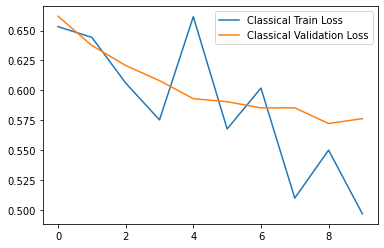

In [18]:
%matplotlib inline
plt.plot(list(range(epoch_num)), classical_train_loss, label='Classical Train Loss')
plt.plot(list(range(epoch_num)), classical_val_loss, label='Classical Validation Loss')
plt.legend()

# 量子网络
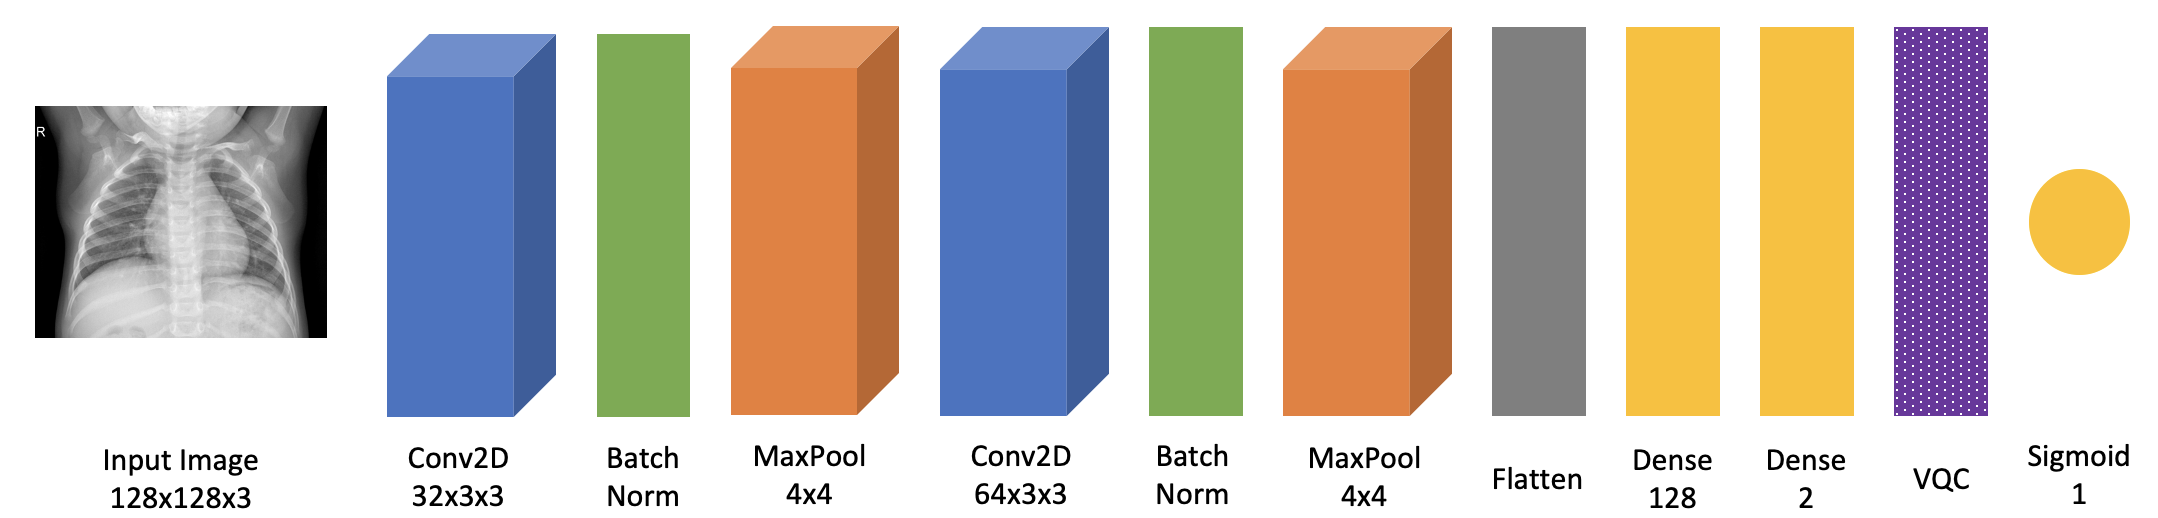

其中量子网络层VQC层架构为
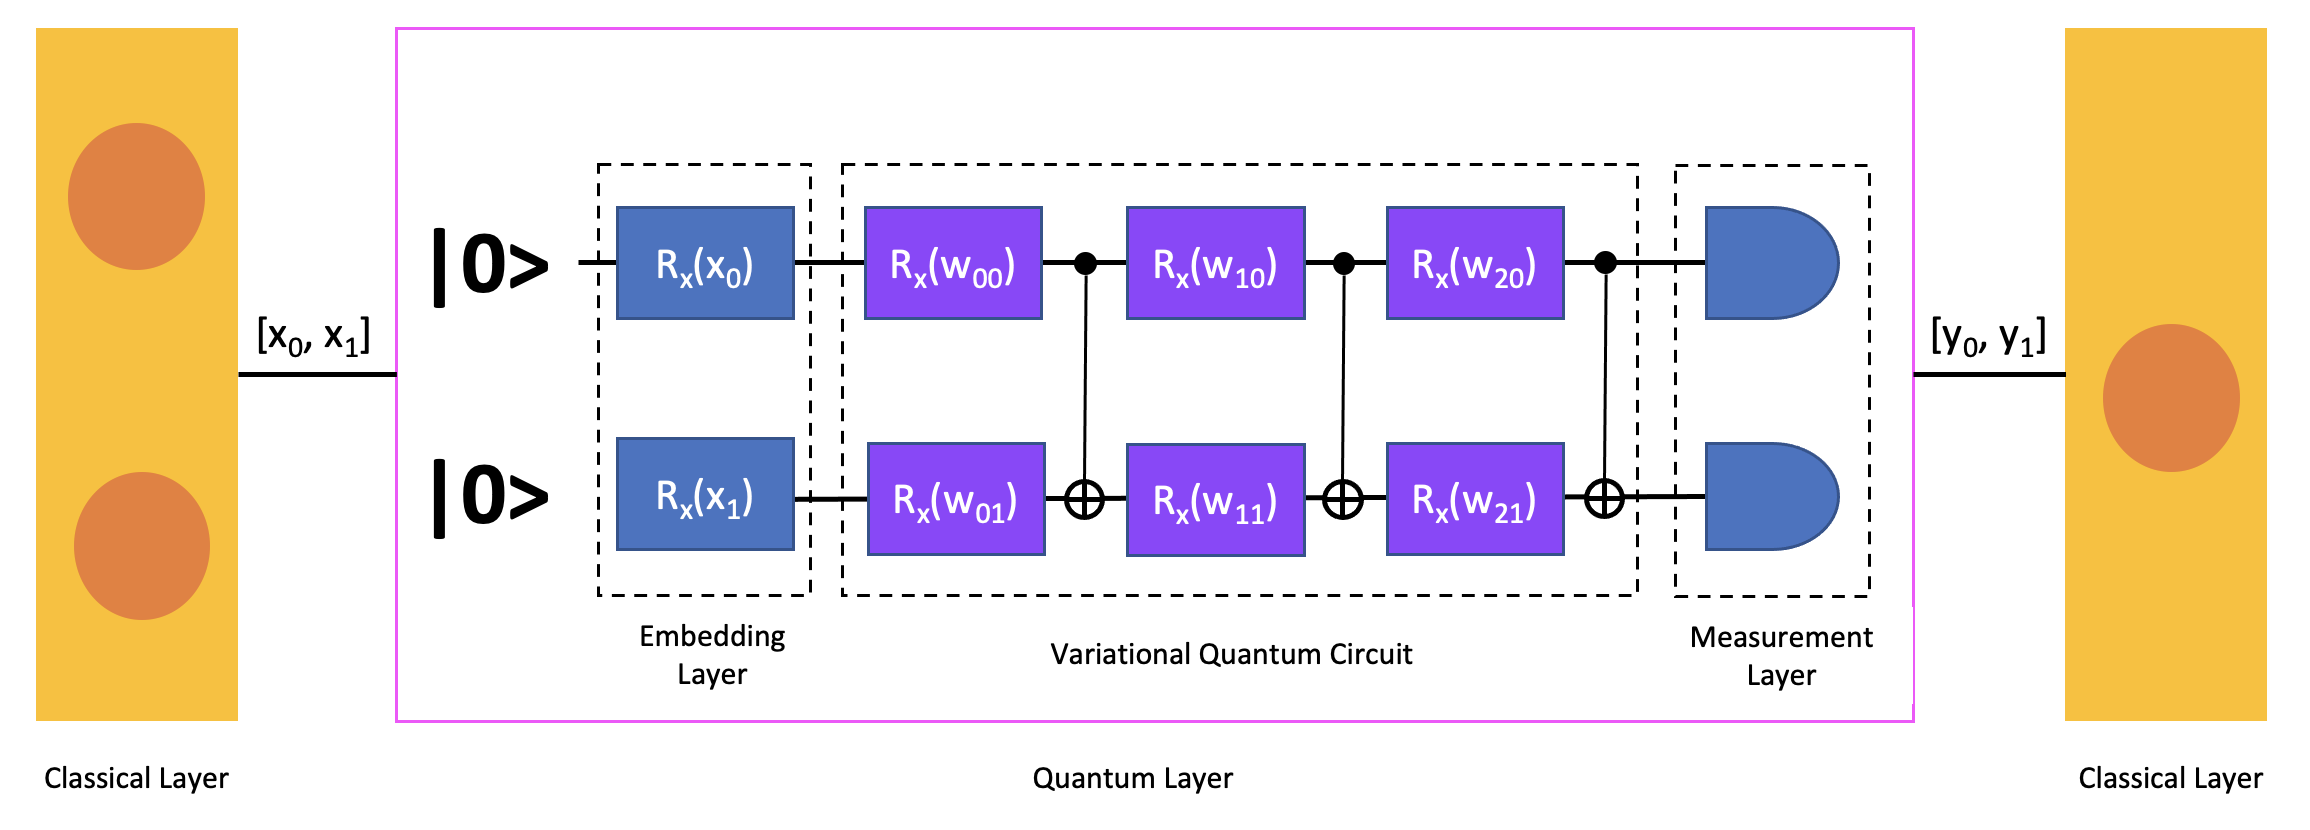

其中，在Embedding Layer中，从前面经典网络中得到的输出\[x0, x1\]以参数的方式被传递到含参量子门中，经过量子线路和测量，得到量子网络的运行结果\[y0, y1\]。

In [1]:
# Embedding Layer构建
from mindquantum.core.circuit import Circuit
from mindquantum.core.gates import X, RX, RZ

encoder = Circuit()
encoder += RX('x0').on(0)
encoder += RX('x1').on(1)
encoder = encoder.no_grad()
encoder = encoder.as_encoder()
encoder.summary()
print(encoder)

/home/ma-user/modelarts-dev/modelarts-sdk/requests/__init__.py:104: RequestsDependencyWarning: urllib3 (1.26.12) or chardet (5.0.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  RequestsDependencyWarning)


=========Circuit Summary=========
|Total number of gates  : 2.    |
|Parameter gates        : 2.    |
|with 2 parameters are  :       |
|x0, x1                        .|
|Number qubit of circuit: 2     |
q0: ──RX(x0)──

q1: ──RX(x1)──


In [2]:
# Variational Quantum Circuit构建
ansatz = Circuit()
for n in range(3):
    ansatz += RX(f'w{n}0').on(0)
    ansatz += RX(f'w{n}1').on(1)
    ansatz += X.on(1, 0)
ansatz.as_ansatz()
ansatz.summary()
print(ansatz)

====================Circuit Summary====================
|Total number of gates  : 9.                          |
|Parameter gates        : 6.                          |
|with 6 parameters are  :                             |
|w00, w01, w10, w11, w20, w21                        .|
|Number qubit of circuit: 2                           |
q0: ──RX(w00)────●────RX(w10)────●────RX(w20)────●──
                 │               │               │
q1: ──RX(w01)────X────RX(w11)────X────RX(w21)────X──


In [3]:
# 构建哈密顿量
from mindquantum.core.operators import QubitOperator
from mindquantum.core.operators import Hamiltonian

hams = [Hamiltonian(QubitOperator(f'Z{i}')) for i in [0, 1]]
print(hams)

[1 [Z0] , 1 [Z1] ]


In [4]:
# 构建网络算子
from mindquantum.simulator import Simulator
from mindquantum.framework import MQLayer
import mindspore as ms

circuit = encoder + ansatz
ms.set_context(mode=ms.PYNATIVE_MODE, device_target="CPU")
ms.set_seed(1)
sim = Simulator('projectq', circuit.n_qubits)
grad_ops = sim.get_expectation_with_grad(hams,
                                         circuit)
vqc_layer = MQLayer(grad_ops)          # 搭建量子神经网络

In [5]:
from mindspore.common.initializer import XavierUniform
from mindspore import nn

class QNetwork(nn.Cell):
    def __init__(self):
        super().__init__()
        in_channels = 3
        hidden_dim = 32
        hidden_dim_l2 = 64
        self.net_sequential = nn.SequentialCell(
            nn.Conv2d(in_channels, hidden_dim, 3, weight_init=XavierUniform()),
            nn.BatchNorm2d(hidden_dim),
            nn.MaxPool2d(4, stride=4),
            nn.Conv2d(hidden_dim, hidden_dim_l2, 3, weight_init=XavierUniform()),
            nn.BatchNorm2d(hidden_dim_l2),
            nn.MaxPool2d(4, stride=4),
            nn.Flatten(),
            nn.Dense(4096, 128, activation='relu', weight_init=XavierUniform()),
            nn.Dense(128, 2, activation='relu', weight_init=XavierUniform()),
        )
        self.vqc = vqc_layer
        self.sigmoid = nn.Dense(2, 1, activation='sigmoid', weight_init=XavierUniform())

    def construct(self, x):
        logits = self.net_sequential(x)
        logits = self.vqc(logits)
        logits = self.sigmoid(logits)
        return logits

检查量子网络的输出格式。

In [6]:
import numpy as np
from mindspore.common.initializer import Uniform

quantum_net = QNetwork()

total_params = 0
for param in quantum_net.trainable_params():
    total_params += np.prod(param.shape)
print('共有%d参数' % total_params)

img = ms.Tensor(shape=(2, 3, 128, 128), dtype=ms.float32, init=Uniform())
x = img
print(quantum_net(x))

共有544171参数
[[0.541669 ]
 [0.5416745]]


In [7]:
ms.set_context(mode=ms.PYNATIVE_MODE, device_target="CPU")

In [8]:
# 重新构造训练集
# 构建数据集
import mindspore.dataset as ds
import matplotlib.pyplot as plt
import numpy as np
from mindspore.dataset import ImageFolderDataset

batch_size = 64
class_index = {'normal': 0, 'opacity': 1}
train_ds_dir = r'./archive/train'
train_ds = ImageFolderDataset(dataset_dir=train_ds_dir, \
    class_indexing=class_index, decode=True)
load_img_ops = ds.transforms.Compose([
    ds.vision.Rescale(1./255, 0),
    ds.vision.Resize((128, 128)),
    ds.vision.HWC2CHW()
])
train_ds = train_ds.map(load_img_ops, input_columns='image')
# 将Label的shape设置成[N, 1]与神经网络的输出适配
train_ds = train_ds.map([lambda x: [x], ds.transforms.TypeCast(np.float32)], input_columns='label')
train_ds = train_ds.batch(batch_size)

# 构造验证集
val_ds_dir = r'./archive/val'
val_ds = ImageFolderDataset(dataset_dir=val_ds_dir, \
    class_indexing=class_index, decode=True)
val_ds = val_ds.map(load_img_ops, input_columns='image')
val_ds = val_ds.map([lambda x: [x], ds.transforms.TypeCast(np.float32)], input_columns='label')
val_ds = val_ds.batch(batch_size)

In [13]:
# 训练量子网络
from mindvision.engine.callback import LossMonitor

learning_rate = 0.01
epoch_num = 10
crit = nn.BCELoss(reduction='mean')
opt = nn.SGD(quantum_net.trainable_params(), learning_rate=learning_rate)

# 使用Model构建训练网络
quantum_model = ms.Model(network=quantum_net, loss_fn=crit, optimizer=opt, metrics={'Loss': nn.Loss()})

history_cb = ms.History()
quantum_val_loss = []
# 量子模型训练
for epoch in range(epoch_num):
    quantum_model.train(epoch+1, train_ds, callbacks=[LossMonitor(learning_rate), history_cb], initial_epoch=epoch)
    eval_result = quantum_model.eval(val_ds)      # 执行模型评估
    quantum_val_loss.append(eval_result['Loss'])
    print(history_cb.epoch, history_cb.history)
    print(eval_result)
quantum_train_loss = history_cb.history['net_output']

Epoch:[  0/  1], step:[    1/   66], loss:[0.627/0.627], time:7402.465 ms, lr:0.01000
Epoch:[  0/  1], step:[    2/   66], loss:[0.680/0.654], time:3303.720 ms, lr:0.01000
Epoch:[  0/  1], step:[    3/   66], loss:[0.639/0.649], time:3101.212 ms, lr:0.01000
Epoch:[  0/  1], step:[    4/   66], loss:[0.630/0.644], time:3292.485 ms, lr:0.01000
Epoch:[  0/  1], step:[    5/   66], loss:[0.623/0.640], time:3191.235 ms, lr:0.01000
Epoch:[  0/  1], step:[    6/   66], loss:[0.642/0.640], time:3410.470 ms, lr:0.01000
Epoch:[  0/  1], step:[    7/   66], loss:[0.649/0.642], time:2697.155 ms, lr:0.01000
Epoch:[  0/  1], step:[    8/   66], loss:[0.652/0.643], time:3199.919 ms, lr:0.01000
Epoch:[  0/  1], step:[    9/   66], loss:[0.653/0.644], time:3093.240 ms, lr:0.01000
Epoch:[  0/  1], step:[   10/   66], loss:[0.648/0.644], time:3280.816 ms, lr:0.01000
Epoch:[  0/  1], step:[   11/   66], loss:[0.670/0.647], time:4193.960 ms, lr:0.01000
Epoch:[  0/  1], step:[   12/   66], loss:[0.657/0.648

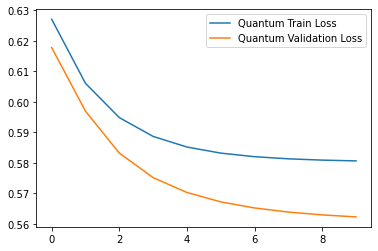

In [14]:
%matplotlib inline
plt.plot(list(range(epoch_num)), quantum_train_loss, label='Quantum Train Loss')
plt.plot(list(range(epoch_num)), quantum_val_loss, label='Quantum Validation Loss')
plt.legend()

论文中，混合网络和经典网络分别运行了20遍和30遍并取了Loss的均值得到了曲线。由于耗时太长，这里只重复一遍。